# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'
import pickle as pkl
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

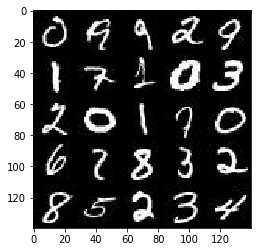

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

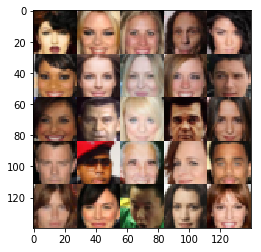

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    r_i = tf.placeholder(tf.float32,(None, image_width, image_height, image_channels), name='real_input')
    z_i = tf.placeholder(tf.float32,(None, z_dim), name='z_input')
    lr = tf.placeholder(tf.float32, name='lr')
    return (r_i, z_i, lr)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    hidden = 128
    alpha = 0.2
    # input images are 28x28x3
    #print("image shape:::", images.get_shape())
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = tf.maximum(alpha * bn1, bn1)
        relu1 = tf.nn.dropout(relu1,0.7)
        #print("relu1 shape:::", relu1.get_shape())
        # 14x14x128
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.nn.dropout(relu2,0.7)
        #print("relu2 shape:::", relu2.get_shape())
        # 7x7x256
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.nn.dropout(relu3,0.7)
        #print("relu3 shape:::", relu3.get_shape())
        # 7x7x512
        
        x4 = tf.layers.conv2d(relu3, 1024, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        #print("relu4 shape:::", relu4.get_shape())
        relu4 = tf.nn.dropout(relu4,0.7)
        # 4x4x1024
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*1024))
        
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.01
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*1024)
        # Reshape it to start the convolutional stack
        #x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.reshape(x1, (-1, 2, 2, 1024))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.7)
        #print("x1 shape:::", x1.get_shape())
        # 2x2x1024 now
        
        x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, 0.7)
        #print("x2 shape:::", x2.get_shape())
        # 4x4x512 now
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 4, strides=1, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #print("x3 shape:::", x3.get_shape())
        x3 = tf.nn.dropout(x3, 0.7)
        # 7x7x256 now
        
        x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        #print("x4 shape:::", x4.get_shape())
        x4 = tf.nn.dropout(x4, 0.7)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        #print("logits shape:::", logits.get_shape())
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    #alpha = 0.2
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    #saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
    
    samples, losses = [], []
    steps = 0
    print_every = 20
    show_every = 200
    print("data_shape::", data_shape[0],data_shape[1],data_shape[2],data_shape[3])
    #tf.reset_default_graph()
    
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images*2
                steps += 1
                # TODO: Train Model
                # Sample random noise for Generators
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 10, input_z, data_shape[3], data_image_mode)
 
        #saver.save(sess, './checkpoints/generator.ckpt')
    return losses
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

data_shape:: 60000 28 28 1
Epoch 1/5... Discriminator Loss: 1.7373... Generator Loss: 0.8947
Epoch 1/5... Discriminator Loss: 1.5705... Generator Loss: 0.8331
Epoch 1/5... Discriminator Loss: 1.4917... Generator Loss: 0.9479
Epoch 1/5... Discriminator Loss: 1.5278... Generator Loss: 0.7804
Epoch 1/5... Discriminator Loss: 1.3039... Generator Loss: 0.7792
Epoch 1/5... Discriminator Loss: 1.5122... Generator Loss: 0.6586
Epoch 1/5... Discriminator Loss: 1.2626... Generator Loss: 0.8827
Epoch 1/5... Discriminator Loss: 1.3165... Generator Loss: 0.7930
Epoch 1/5... Discriminator Loss: 1.2549... Generator Loss: 0.9396
Epoch 1/5... Discriminator Loss: 1.2814... Generator Loss: 0.9258


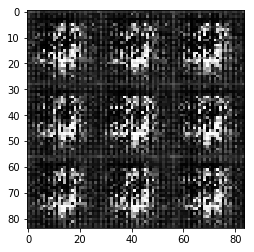

Epoch 1/5... Discriminator Loss: 1.3832... Generator Loss: 0.6960
Epoch 1/5... Discriminator Loss: 1.4482... Generator Loss: 0.7535
Epoch 1/5... Discriminator Loss: 1.4137... Generator Loss: 0.7657
Epoch 1/5... Discriminator Loss: 1.3035... Generator Loss: 0.8498
Epoch 1/5... Discriminator Loss: 1.5249... Generator Loss: 0.6859
Epoch 1/5... Discriminator Loss: 1.3186... Generator Loss: 0.7190
Epoch 1/5... Discriminator Loss: 1.3880... Generator Loss: 0.8421
Epoch 1/5... Discriminator Loss: 1.3134... Generator Loss: 0.8693
Epoch 1/5... Discriminator Loss: 1.3275... Generator Loss: 0.7125
Epoch 1/5... Discriminator Loss: 1.3054... Generator Loss: 0.7311


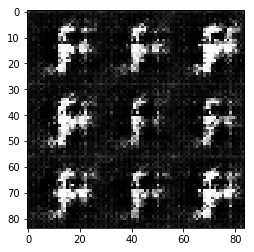

Epoch 1/5... Discriminator Loss: 1.3299... Generator Loss: 0.8503
Epoch 1/5... Discriminator Loss: 1.3247... Generator Loss: 0.7426
Epoch 1/5... Discriminator Loss: 1.3056... Generator Loss: 0.8396
Epoch 1/5... Discriminator Loss: 1.4137... Generator Loss: 0.9026
Epoch 1/5... Discriminator Loss: 1.2504... Generator Loss: 0.8723
Epoch 1/5... Discriminator Loss: 1.3183... Generator Loss: 0.9074
Epoch 1/5... Discriminator Loss: 1.1396... Generator Loss: 0.8953
Epoch 1/5... Discriminator Loss: 1.2576... Generator Loss: 1.0264
Epoch 1/5... Discriminator Loss: 1.2992... Generator Loss: 0.8373
Epoch 1/5... Discriminator Loss: 1.3745... Generator Loss: 0.9107


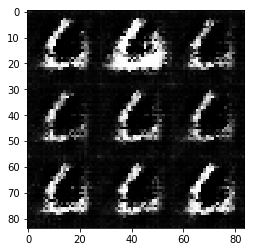

Epoch 1/5... Discriminator Loss: 1.2024... Generator Loss: 0.9074
Epoch 1/5... Discriminator Loss: 1.2496... Generator Loss: 0.9372
Epoch 1/5... Discriminator Loss: 1.2543... Generator Loss: 0.9223
Epoch 1/5... Discriminator Loss: 1.0699... Generator Loss: 1.0669
Epoch 1/5... Discriminator Loss: 1.3285... Generator Loss: 0.8138
Epoch 1/5... Discriminator Loss: 1.1991... Generator Loss: 0.8750
Epoch 1/5... Discriminator Loss: 1.3518... Generator Loss: 0.8419
Epoch 1/5... Discriminator Loss: 1.4183... Generator Loss: 0.6747
Epoch 1/5... Discriminator Loss: 1.4377... Generator Loss: 0.8347
Epoch 1/5... Discriminator Loss: 1.3431... Generator Loss: 0.8156


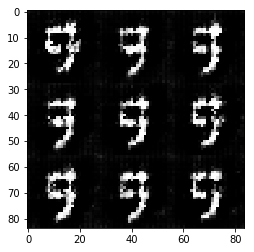

Epoch 1/5... Discriminator Loss: 1.1950... Generator Loss: 0.8969
Epoch 1/5... Discriminator Loss: 1.3258... Generator Loss: 0.7859
Epoch 1/5... Discriminator Loss: 1.2177... Generator Loss: 0.8776
Epoch 1/5... Discriminator Loss: 1.1897... Generator Loss: 0.9781
Epoch 1/5... Discriminator Loss: 1.3169... Generator Loss: 0.8110
Epoch 1/5... Discriminator Loss: 1.2180... Generator Loss: 1.0221
Epoch 2/5... Discriminator Loss: 1.4956... Generator Loss: 0.7639
Epoch 2/5... Discriminator Loss: 1.3136... Generator Loss: 0.8926
Epoch 2/5... Discriminator Loss: 1.2524... Generator Loss: 0.8348
Epoch 2/5... Discriminator Loss: 1.2513... Generator Loss: 0.8924


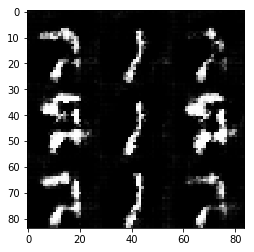

Epoch 2/5... Discriminator Loss: 1.3368... Generator Loss: 0.8900
Epoch 2/5... Discriminator Loss: 1.2754... Generator Loss: 0.8596
Epoch 2/5... Discriminator Loss: 1.1206... Generator Loss: 0.9148
Epoch 2/5... Discriminator Loss: 1.1707... Generator Loss: 0.9710
Epoch 2/5... Discriminator Loss: 1.2718... Generator Loss: 0.7837
Epoch 2/5... Discriminator Loss: 1.1854... Generator Loss: 0.7824
Epoch 2/5... Discriminator Loss: 1.0930... Generator Loss: 1.0264
Epoch 2/5... Discriminator Loss: 1.2104... Generator Loss: 0.8873
Epoch 2/5... Discriminator Loss: 1.4051... Generator Loss: 0.9092
Epoch 2/5... Discriminator Loss: 1.1950... Generator Loss: 0.8970


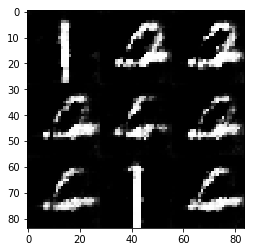

Epoch 2/5... Discriminator Loss: 1.2021... Generator Loss: 0.9239
Epoch 2/5... Discriminator Loss: 1.2204... Generator Loss: 0.7083
Epoch 2/5... Discriminator Loss: 1.0338... Generator Loss: 1.1066
Epoch 2/5... Discriminator Loss: 1.2221... Generator Loss: 0.9063
Epoch 2/5... Discriminator Loss: 1.0557... Generator Loss: 0.9125
Epoch 2/5... Discriminator Loss: 1.2452... Generator Loss: 0.9236
Epoch 2/5... Discriminator Loss: 1.2682... Generator Loss: 0.9365
Epoch 2/5... Discriminator Loss: 1.2709... Generator Loss: 0.8738
Epoch 2/5... Discriminator Loss: 1.2589... Generator Loss: 0.8193
Epoch 2/5... Discriminator Loss: 1.3208... Generator Loss: 0.9985


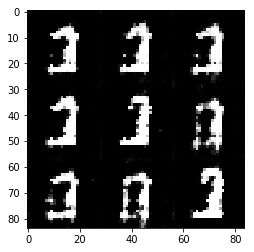

Epoch 2/5... Discriminator Loss: 1.0512... Generator Loss: 1.1149
Epoch 2/5... Discriminator Loss: 1.1555... Generator Loss: 0.8987
Epoch 2/5... Discriminator Loss: 1.2671... Generator Loss: 0.9243
Epoch 2/5... Discriminator Loss: 1.4752... Generator Loss: 0.7833
Epoch 2/5... Discriminator Loss: 1.3509... Generator Loss: 0.9282
Epoch 2/5... Discriminator Loss: 0.9496... Generator Loss: 0.9440
Epoch 2/5... Discriminator Loss: 1.2475... Generator Loss: 0.8856
Epoch 2/5... Discriminator Loss: 1.1815... Generator Loss: 0.9333
Epoch 2/5... Discriminator Loss: 1.1763... Generator Loss: 0.9882
Epoch 2/5... Discriminator Loss: 1.3259... Generator Loss: 0.9892


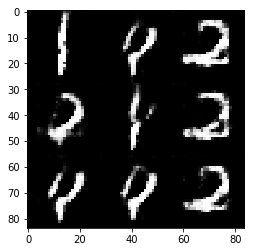

Epoch 2/5... Discriminator Loss: 1.3534... Generator Loss: 0.8875
Epoch 2/5... Discriminator Loss: 1.2509... Generator Loss: 0.8245
Epoch 2/5... Discriminator Loss: 1.1311... Generator Loss: 1.0223
Epoch 2/5... Discriminator Loss: 1.1141... Generator Loss: 0.9070
Epoch 2/5... Discriminator Loss: 1.2114... Generator Loss: 0.9354
Epoch 2/5... Discriminator Loss: 1.2898... Generator Loss: 0.8626
Epoch 2/5... Discriminator Loss: 1.3852... Generator Loss: 0.7623
Epoch 2/5... Discriminator Loss: 1.1102... Generator Loss: 1.0112
Epoch 2/5... Discriminator Loss: 1.4565... Generator Loss: 0.7931
Epoch 2/5... Discriminator Loss: 0.9506... Generator Loss: 1.0465


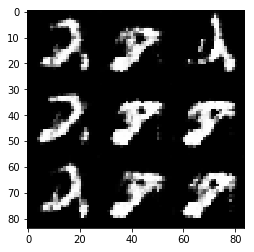

Epoch 2/5... Discriminator Loss: 1.2620... Generator Loss: 1.0513
Epoch 2/5... Discriminator Loss: 1.3561... Generator Loss: 0.8034
Epoch 2/5... Discriminator Loss: 1.1994... Generator Loss: 0.9254
Epoch 3/5... Discriminator Loss: 1.3588... Generator Loss: 0.7942
Epoch 3/5... Discriminator Loss: 1.2276... Generator Loss: 0.9311
Epoch 3/5... Discriminator Loss: 1.3834... Generator Loss: 0.8161
Epoch 3/5... Discriminator Loss: 1.1832... Generator Loss: 0.9415
Epoch 3/5... Discriminator Loss: 1.3056... Generator Loss: 0.8630
Epoch 3/5... Discriminator Loss: 1.3152... Generator Loss: 0.8686
Epoch 3/5... Discriminator Loss: 1.2196... Generator Loss: 0.8137


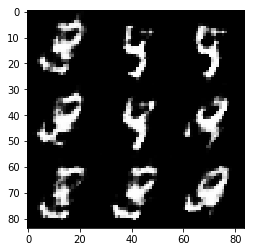

Epoch 3/5... Discriminator Loss: 1.1159... Generator Loss: 0.9140
Epoch 3/5... Discriminator Loss: 1.3882... Generator Loss: 0.7184
Epoch 3/5... Discriminator Loss: 1.3129... Generator Loss: 0.8521
Epoch 3/5... Discriminator Loss: 1.1290... Generator Loss: 0.9617
Epoch 3/5... Discriminator Loss: 1.2579... Generator Loss: 0.9289
Epoch 3/5... Discriminator Loss: 1.0305... Generator Loss: 0.9639
Epoch 3/5... Discriminator Loss: 1.3133... Generator Loss: 0.9267
Epoch 3/5... Discriminator Loss: 1.1538... Generator Loss: 0.9846
Epoch 3/5... Discriminator Loss: 1.2017... Generator Loss: 0.9671
Epoch 3/5... Discriminator Loss: 1.1324... Generator Loss: 1.0971


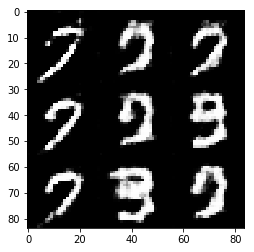

Epoch 3/5... Discriminator Loss: 1.3079... Generator Loss: 0.7518
Epoch 3/5... Discriminator Loss: 1.2589... Generator Loss: 0.7847
Epoch 3/5... Discriminator Loss: 0.9230... Generator Loss: 1.0948
Epoch 3/5... Discriminator Loss: 1.1295... Generator Loss: 0.9709
Epoch 3/5... Discriminator Loss: 1.3400... Generator Loss: 0.9678
Epoch 3/5... Discriminator Loss: 1.1055... Generator Loss: 0.9772
Epoch 3/5... Discriminator Loss: 1.2036... Generator Loss: 1.0112
Epoch 3/5... Discriminator Loss: 1.2233... Generator Loss: 0.7780
Epoch 3/5... Discriminator Loss: 1.2327... Generator Loss: 0.8109
Epoch 3/5... Discriminator Loss: 1.2771... Generator Loss: 0.9100


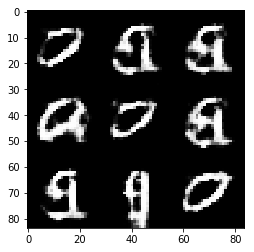

Epoch 3/5... Discriminator Loss: 1.3537... Generator Loss: 0.8161
Epoch 3/5... Discriminator Loss: 1.1411... Generator Loss: 0.9974
Epoch 3/5... Discriminator Loss: 1.2216... Generator Loss: 0.8957
Epoch 3/5... Discriminator Loss: 1.1802... Generator Loss: 0.8685
Epoch 3/5... Discriminator Loss: 1.1713... Generator Loss: 0.9403
Epoch 3/5... Discriminator Loss: 1.1528... Generator Loss: 0.9807
Epoch 3/5... Discriminator Loss: 1.1708... Generator Loss: 0.9989
Epoch 3/5... Discriminator Loss: 1.2692... Generator Loss: 1.0868
Epoch 3/5... Discriminator Loss: 1.2959... Generator Loss: 0.9156
Epoch 3/5... Discriminator Loss: 0.9521... Generator Loss: 0.9971


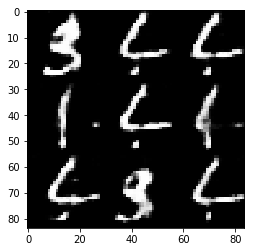

Epoch 3/5... Discriminator Loss: 1.3042... Generator Loss: 0.8553
Epoch 3/5... Discriminator Loss: 1.2411... Generator Loss: 0.9518
Epoch 3/5... Discriminator Loss: 1.0810... Generator Loss: 1.1776
Epoch 3/5... Discriminator Loss: 1.0090... Generator Loss: 1.1946
Epoch 3/5... Discriminator Loss: 1.1897... Generator Loss: 0.8700
Epoch 3/5... Discriminator Loss: 1.2557... Generator Loss: 1.0675
Epoch 3/5... Discriminator Loss: 1.1666... Generator Loss: 1.0348
Epoch 3/5... Discriminator Loss: 1.2697... Generator Loss: 0.7560
Epoch 3/5... Discriminator Loss: 1.2154... Generator Loss: 0.9673
Epoch 3/5... Discriminator Loss: 1.1548... Generator Loss: 0.9315


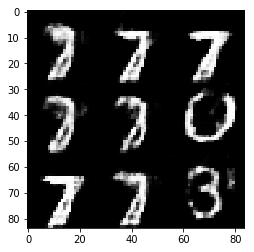

Epoch 4/5... Discriminator Loss: 1.1063... Generator Loss: 0.8481
Epoch 4/5... Discriminator Loss: 1.1324... Generator Loss: 0.9795
Epoch 4/5... Discriminator Loss: 1.3376... Generator Loss: 1.0257
Epoch 4/5... Discriminator Loss: 1.0541... Generator Loss: 1.1412
Epoch 4/5... Discriminator Loss: 1.2101... Generator Loss: 0.9986
Epoch 4/5... Discriminator Loss: 1.1267... Generator Loss: 0.9082
Epoch 4/5... Discriminator Loss: 1.2509... Generator Loss: 0.8381
Epoch 4/5... Discriminator Loss: 1.2460... Generator Loss: 1.0410
Epoch 4/5... Discriminator Loss: 1.1594... Generator Loss: 0.8911
Epoch 4/5... Discriminator Loss: 1.2314... Generator Loss: 0.9877


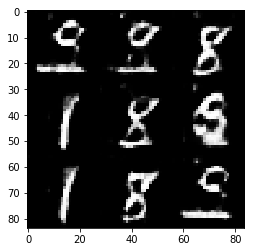

Epoch 4/5... Discriminator Loss: 1.1461... Generator Loss: 1.0023
Epoch 4/5... Discriminator Loss: 1.2036... Generator Loss: 0.9824
Epoch 4/5... Discriminator Loss: 1.1304... Generator Loss: 1.1319
Epoch 4/5... Discriminator Loss: 1.1752... Generator Loss: 0.9976
Epoch 4/5... Discriminator Loss: 0.8871... Generator Loss: 1.2547
Epoch 4/5... Discriminator Loss: 1.0226... Generator Loss: 1.1133
Epoch 4/5... Discriminator Loss: 1.1631... Generator Loss: 0.9552
Epoch 4/5... Discriminator Loss: 1.1670... Generator Loss: 1.1936
Epoch 4/5... Discriminator Loss: 1.0631... Generator Loss: 0.9528
Epoch 4/5... Discriminator Loss: 1.2174... Generator Loss: 0.9688


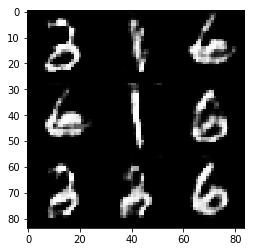

Epoch 4/5... Discriminator Loss: 1.1317... Generator Loss: 1.0508
Epoch 4/5... Discriminator Loss: 1.2500... Generator Loss: 0.9441
Epoch 4/5... Discriminator Loss: 1.1289... Generator Loss: 1.0683
Epoch 4/5... Discriminator Loss: 0.9825... Generator Loss: 1.0578
Epoch 4/5... Discriminator Loss: 1.2462... Generator Loss: 0.9238
Epoch 4/5... Discriminator Loss: 1.2410... Generator Loss: 0.9422
Epoch 4/5... Discriminator Loss: 1.2459... Generator Loss: 1.0985
Epoch 4/5... Discriminator Loss: 1.1952... Generator Loss: 0.9632
Epoch 4/5... Discriminator Loss: 1.0558... Generator Loss: 1.0263
Epoch 4/5... Discriminator Loss: 1.0524... Generator Loss: 1.1340


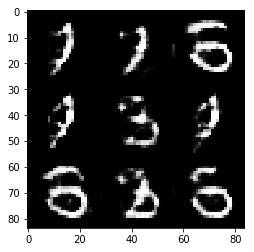

Epoch 4/5... Discriminator Loss: 1.1061... Generator Loss: 1.0250
Epoch 4/5... Discriminator Loss: 1.3120... Generator Loss: 1.0613
Epoch 4/5... Discriminator Loss: 1.1468... Generator Loss: 0.9843
Epoch 4/5... Discriminator Loss: 1.1541... Generator Loss: 1.0222
Epoch 4/5... Discriminator Loss: 1.3093... Generator Loss: 0.9227
Epoch 4/5... Discriminator Loss: 1.2762... Generator Loss: 1.0481
Epoch 4/5... Discriminator Loss: 1.0494... Generator Loss: 0.9202
Epoch 4/5... Discriminator Loss: 1.2681... Generator Loss: 0.8698
Epoch 4/5... Discriminator Loss: 1.2862... Generator Loss: 1.0746
Epoch 4/5... Discriminator Loss: 1.3376... Generator Loss: 0.8019


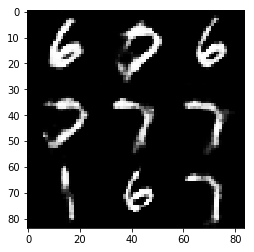

Epoch 4/5... Discriminator Loss: 1.0649... Generator Loss: 1.1254
Epoch 4/5... Discriminator Loss: 1.4357... Generator Loss: 0.7841
Epoch 4/5... Discriminator Loss: 0.9703... Generator Loss: 1.0705
Epoch 4/5... Discriminator Loss: 1.1783... Generator Loss: 0.9635
Epoch 4/5... Discriminator Loss: 1.2398... Generator Loss: 0.9454
Epoch 4/5... Discriminator Loss: 1.0174... Generator Loss: 1.1839
Epoch 4/5... Discriminator Loss: 1.1264... Generator Loss: 0.8823
Epoch 5/5... Discriminator Loss: 1.0612... Generator Loss: 0.9784
Epoch 5/5... Discriminator Loss: 1.1765... Generator Loss: 0.9574
Epoch 5/5... Discriminator Loss: 1.2521... Generator Loss: 0.8759


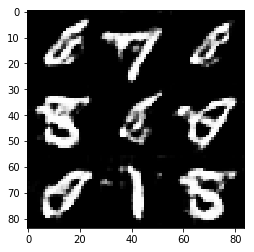

Epoch 5/5... Discriminator Loss: 1.1882... Generator Loss: 1.1312
Epoch 5/5... Discriminator Loss: 1.2613... Generator Loss: 0.8371
Epoch 5/5... Discriminator Loss: 1.1379... Generator Loss: 1.0429
Epoch 5/5... Discriminator Loss: 1.0961... Generator Loss: 1.0503
Epoch 5/5... Discriminator Loss: 0.9035... Generator Loss: 1.2573
Epoch 5/5... Discriminator Loss: 1.2868... Generator Loss: 0.7490
Epoch 5/5... Discriminator Loss: 1.1203... Generator Loss: 1.0041
Epoch 5/5... Discriminator Loss: 1.2559... Generator Loss: 0.9814
Epoch 5/5... Discriminator Loss: 1.3359... Generator Loss: 0.8817
Epoch 5/5... Discriminator Loss: 1.2103... Generator Loss: 0.9722


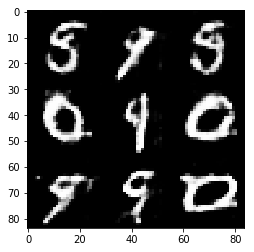

Epoch 5/5... Discriminator Loss: 1.2037... Generator Loss: 1.1081
Epoch 5/5... Discriminator Loss: 1.2098... Generator Loss: 0.9929
Epoch 5/5... Discriminator Loss: 1.2890... Generator Loss: 1.0166
Epoch 5/5... Discriminator Loss: 1.1646... Generator Loss: 0.8726
Epoch 5/5... Discriminator Loss: 1.3767... Generator Loss: 0.9123
Epoch 5/5... Discriminator Loss: 1.1948... Generator Loss: 1.0641
Epoch 5/5... Discriminator Loss: 1.0651... Generator Loss: 0.9786
Epoch 5/5... Discriminator Loss: 1.2036... Generator Loss: 0.8534
Epoch 5/5... Discriminator Loss: 1.2376... Generator Loss: 1.0935
Epoch 5/5... Discriminator Loss: 0.9809... Generator Loss: 1.2311


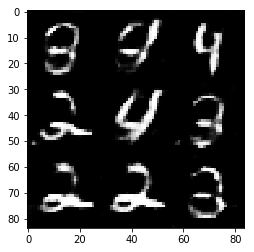

Epoch 5/5... Discriminator Loss: 1.1302... Generator Loss: 1.0983
Epoch 5/5... Discriminator Loss: 1.2557... Generator Loss: 0.9956
Epoch 5/5... Discriminator Loss: 1.2049... Generator Loss: 0.9494
Epoch 5/5... Discriminator Loss: 1.1987... Generator Loss: 1.1891
Epoch 5/5... Discriminator Loss: 1.1956... Generator Loss: 1.1029
Epoch 5/5... Discriminator Loss: 1.0330... Generator Loss: 1.0014
Epoch 5/5... Discriminator Loss: 1.0761... Generator Loss: 1.1424
Epoch 5/5... Discriminator Loss: 1.1988... Generator Loss: 0.9498
Epoch 5/5... Discriminator Loss: 1.3451... Generator Loss: 0.8210
Epoch 5/5... Discriminator Loss: 1.2024... Generator Loss: 1.0107


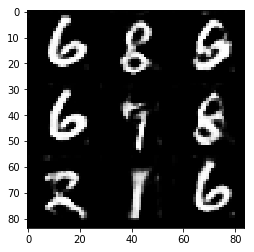

Epoch 5/5... Discriminator Loss: 1.1257... Generator Loss: 1.0392
Epoch 5/5... Discriminator Loss: 1.3113... Generator Loss: 1.0842
Epoch 5/5... Discriminator Loss: 1.1264... Generator Loss: 0.9139
Epoch 5/5... Discriminator Loss: 1.2078... Generator Loss: 0.8949
Epoch 5/5... Discriminator Loss: 1.0736... Generator Loss: 1.0559
Epoch 5/5... Discriminator Loss: 1.1077... Generator Loss: 0.9583
Epoch 5/5... Discriminator Loss: 1.0567... Generator Loss: 1.1350
Epoch 5/5... Discriminator Loss: 1.2327... Generator Loss: 0.9902
Epoch 5/5... Discriminator Loss: 0.9741... Generator Loss: 1.1189
Epoch 5/5... Discriminator Loss: 1.0144... Generator Loss: 1.0398


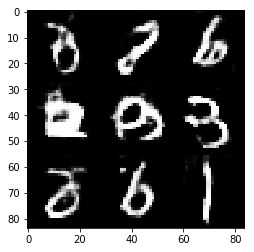

Epoch 5/5... Discriminator Loss: 1.4075... Generator Loss: 0.7701
Epoch 5/5... Discriminator Loss: 1.2417... Generator Loss: 1.2894
Epoch 5/5... Discriminator Loss: 1.1814... Generator Loss: 0.9495
Epoch 5/5... Discriminator Loss: 1.2091... Generator Loss: 1.1387


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

data_shape:: 202599 28 28 3
Epoch 1/1... Discriminator Loss: 1.5422... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.7753... Generator Loss: 0.9530
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.8891
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 1.0484
Epoch 1/1... Discriminator Loss: 1.2155... Generator Loss: 1.1049
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 1.0558
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 0.9901
Epoch 1/1... Discriminator Loss: 1.1946... Generator Loss: 0.9540
Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 1.0072
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 0.9402


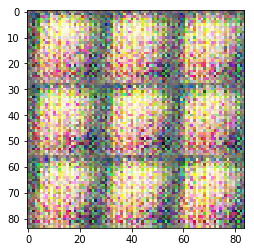

Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.9438
Epoch 1/1... Discriminator Loss: 0.8239... Generator Loss: 1.4690
Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 1.0027
Epoch 1/1... Discriminator Loss: 0.8506... Generator Loss: 1.3188
Epoch 1/1... Discriminator Loss: 0.8224... Generator Loss: 1.0964
Epoch 1/1... Discriminator Loss: 2.7501... Generator Loss: 0.5314
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.5420... Generator Loss: 0.9033
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.9896
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.9211


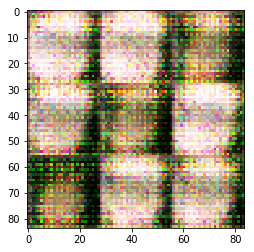

Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 0.9232
Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 0.9593
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.9372
Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.5231... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.8688
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.8761
Epoch 1/1... Discriminator Loss: 1.6236... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.5231... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 0.8242


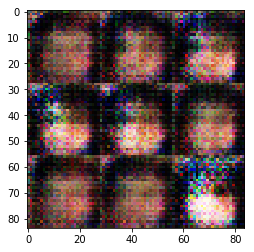

Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 1.0001
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 0.9166
Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 0.8401
Epoch 1/1... Discriminator Loss: 1.0821... Generator Loss: 1.0839
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.8817
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.8094


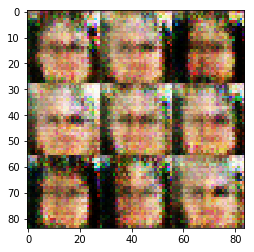

Epoch 1/1... Discriminator Loss: 1.6326... Generator Loss: 1.1195
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.9525
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.4851... Generator Loss: 0.8585
Epoch 1/1... Discriminator Loss: 1.5564... Generator Loss: 1.0183
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 1.5303... Generator Loss: 0.5987
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.9452


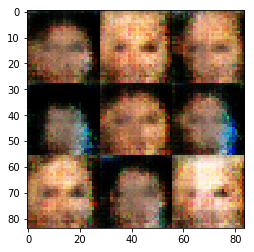

Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.8410
Epoch 1/1... Discriminator Loss: 1.6332... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.6818... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.5307... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 1.5601... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.4973... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.6226
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.7245


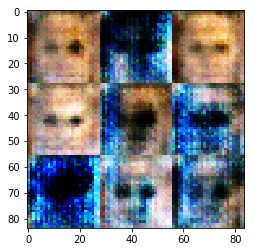

Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.8051
Epoch 1/1... Discriminator Loss: 1.5174... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.4927... Generator Loss: 0.7755
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.7736


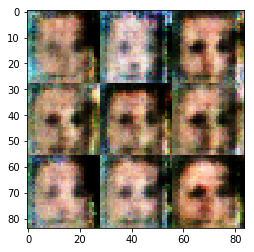

Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.5018... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.6481
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.5505... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.8453
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.8907
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.7620


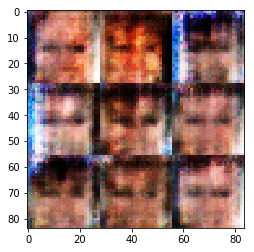

Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.8688
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.8700
Epoch 1/1... Discriminator Loss: 1.3012... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.6443
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.6836


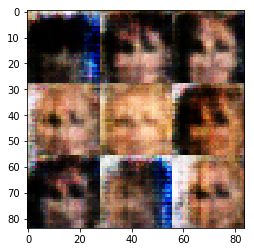

Epoch 1/1... Discriminator Loss: 1.4972... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.5852... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 1.5021... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.4925... Generator Loss: 0.7559


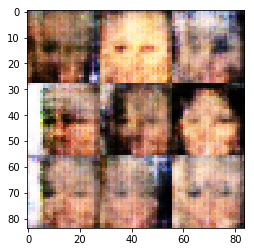

Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.5157... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.7694


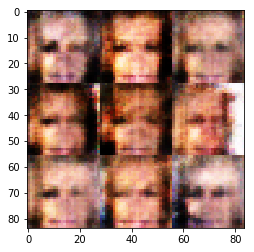

Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.6364
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.4934... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.6781
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.8544


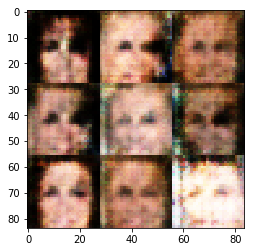

Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.4801... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.6443


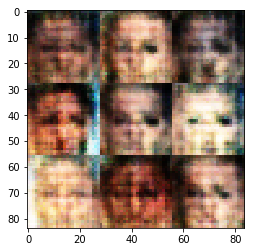

Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.4642... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.5242... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.7199


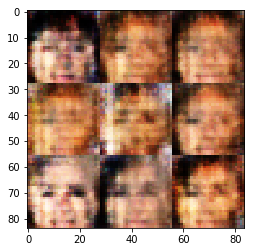

Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.5212... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 1.5043... Generator Loss: 0.6231
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.5969
Epoch 1/1... Discriminator Loss: 1.4661... Generator Loss: 0.6226
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.4710... Generator Loss: 0.7004


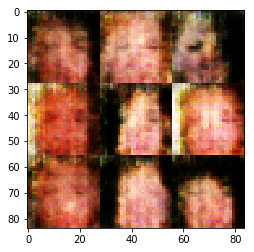

Epoch 1/1... Discriminator Loss: 1.4792... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.7065


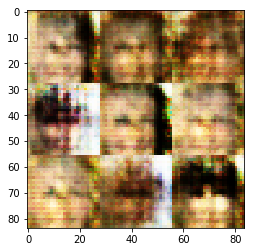

Epoch 1/1... Discriminator Loss: 1.6274... Generator Loss: 0.5712
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.4730... Generator Loss: 0.6903
Epoch 1/1... Discriminator Loss: 1.5166... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.6523
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.6540


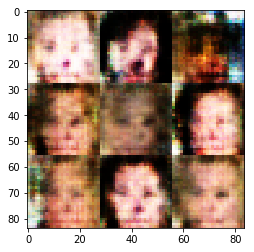

Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.5122... Generator Loss: 0.5709
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.6080
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.5714


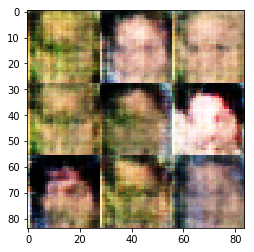

Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.6059
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.9466
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 1.5202... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.7287


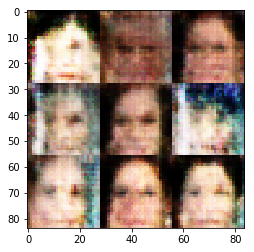

Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.6036
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7407


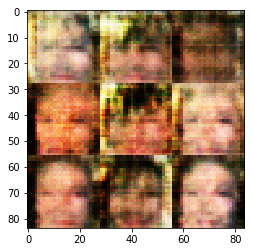

Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.8034


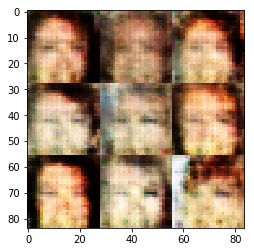

Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.8182
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.6169
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.7211


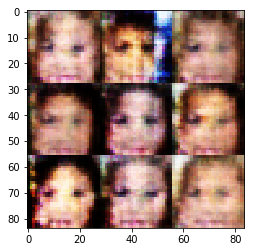

Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.6232
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.7242
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.6874


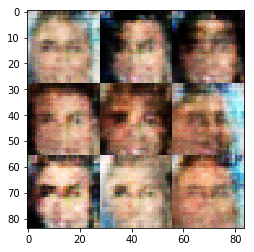

Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.4811... Generator Loss: 0.6035
Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.7120


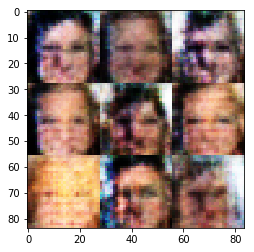

Epoch 1/1... Discriminator Loss: 1.5037... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.6428
Epoch 1/1... Discriminator Loss: 1.4759... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.5046... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7044


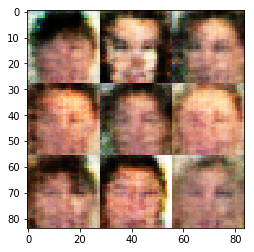

Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.6137
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.4637... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.6769


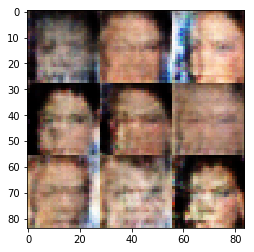

Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.6104
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.5181... Generator Loss: 0.5749
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.7045


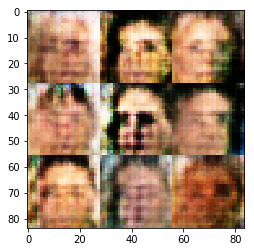

Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.4650... Generator Loss: 0.6499
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.4966... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.6781


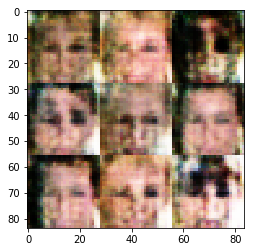

Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.6207
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.6712
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.6458


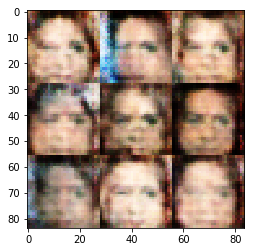

Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.8073
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.7302


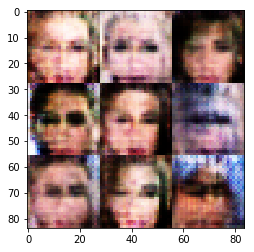

Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.6164
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.6430
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7071


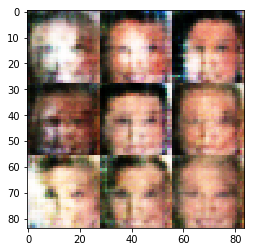

Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.7386


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.